#  Real Estate Price Prediction

## Описание задачи

Цель - предсказать стоимость квартиры 

Зачем?  

_В банках, страховых компаниях:_
- Узнать истинную стоимость имущества (залога)
- Принять решение о выдаче ипотеки/страховки
- Принять решение о % по ипотеке/страховке
  
_На площадках объявлений (Авито, Циан, ...):_
- Найти недооцененные квартиры (~ выгодные предложения), показать их пользователям
- Показывать рыночную стоимость квартиры пользователям
- Для тех, кто продает квартиру, рекомендовать цену продажи

_Для инвесторов в недвижимость:_
- Определять рыночную стоимость квартир
- Поиск недооцененных активов
- Торговля на рынке недвижимости

## Содержание
* [1. Загрузка данных](#load)
* [2. Приведение типов](#types)
* [3. EDA](#eda)
    * [3.1. Целевая переменная](#target)
    * [3.2. Остальные переменные](#other_val)
        * [3.2.1. Количественные переменные](#numeric)
        * [3.2.2. Категориальные переменные](#category)
        * [3.2.3. Визуализация переменных - гистограммы](#hist)
        * [3.2.4. Матрица корреляции](#corr_matrix)
* [4. Обработка исходных данных](#prep)
    * [4.1. Обработка выбросов](#outlier)
        * [4.1.1. Square](#square)
        * [4.1.2. KitchenSquare](#kitchen_square)
        * [4.1.3. LifeSquare](#life_square)
        * [4.1.4. Rooms](#rooms)
        * [4.1.5. HouseFloor, Floor](#house_floor)
        * [4.1.6. HouseYear](#house_year)
    * [4.2. Обработка пропусков](#nan)
        * [4.2.1. Healthcare_1](#healthcare_1)
        * [4.2.2. LifeSquare](#life_square_nan)
    * [4.3. Подготовка исходных данных](#prep_script)
* [5. Построение новых признаков](#new_features)
    * [5.1. Ecology_2, Ecology_3, Shops_2](#binary)
    * [5.2. DistrictSize, IsDistrictLarge](#district_size)
    * [5.3. MedPriceByDistrict](#med_price_by_district)
    * [5.4. Floor_cat](#floor_cat)
    * [5.5. Year_cat](#year_cat)
    * [5.6. MedPriceByFloor](#med_price_by_floor)
    * [5.7. MedPriceByYear](#med_price_by_year)
    * [5.8. MedPriceByRooms](#med_price_by_rooms)
    * [5.9. Med_District_Price](#med_district_price)
    * [5.10. LifeSquareShare](#life_square_share)
    * [5.11. Генерация новых признаков](#feature_generator)
* [6. Отбор признаков](#feature_select)
* [7. Разбиение на train и test](#ds_separating)
* [8. Построение модели Boosting](#model)
    * [8.1. Подбор параметров](#parameters)
    * [8.2. Обучение модели](#learn)
* [9. Оценка модели](#estimation)
    * [9.1. Функция evaluate_preds](#evaluate_preds)
    * [9.2. Кросс валидация](#cross_validation)
    * [9.3. Важность признаков](#feature_importances)
* [10. Прогнозирование на тестовом датасете](#predictions)

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams.update({'font.size': 14})

**Функция проверки модели**

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Функция проверки модели"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
TEST_DATASET_PATH = './test.csv'

# 1. Загрузка данных <a class='anchor' id='load'>

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df = train_df.set_index('Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


**Описание датасета**

Статистические данные о ряде квартир.
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры - **target величина**

In [7]:
train_df.shape

(10000, 19)

In [8]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11809 to 7202
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

# 2. Приведение типов <a class='anchor' id='types'>

In [10]:
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)
# train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [11]:
train_df.dtypes

DistrictId        object
Rooms              int32
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int32
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

# 3. EDA <a class='anchor' id='eda'>

## 3.1. Целевая переменная <a class='anchor' id='target'>

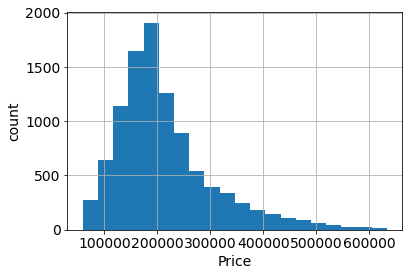

In [12]:
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.show()

In [13]:
target_mean = train_df['Price'].mean()
target_median = train_df['Price'].median()
print(f'Среднее арифметическое: {target_mean}\nМедиана: {target_median}')

Среднее арифметическое: 214138.8573987384
Медиана: 192269.64487934904


## 3.2. Остальные переменные <a class='anchor' id='other_val'>

### 3.2.1. Количественные переменные <a class='anchor' id='numeric'>

In [14]:
df_num_features = train_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,,,,,,,,,,,,,,,
11809,3,115.027311,NaN,10.0,4,10,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
3013,1,39.832524,23.169223,8.0,7,8,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
8215,3,78.342215,47.671972,10.0,2,17,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
2352,1,40.409907,NaN,1.0,10,22,1977,0.007122,1,264,0,NaN,0,1,168106.007630
13866,2,64.285067,38.562517,9.0,16,16,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


### 3.2.2. Категориальные переменные <a class='anchor' id='category'>

In [15]:
df_cat_features = train_df.select_dtypes(include=['category', 'object'])
df_cat_features.head()

,DistrictId,Ecology_2,Ecology_3,Shops_2
Id,,,,
11809,27,B,B,B
3013,22,B,B,B
8215,1,B,B,B
2352,1,B,B,B
13866,94,B,B,B


### 3.2.3. Визуализация переменных - гистограммы <a class='anchor' id='hist'>

In [16]:
df_num_features.drop('Price', axis=1, inplace=True)

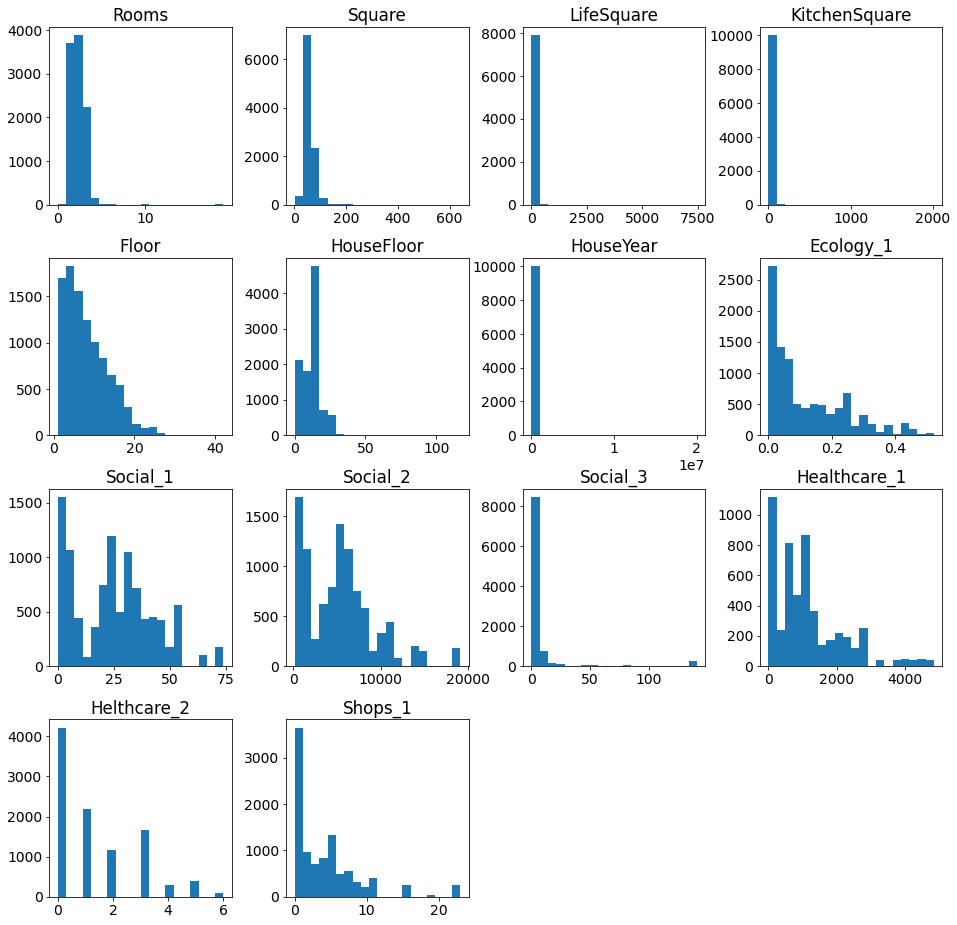

In [17]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

Выбросы в признаках Square, LifeSquare, KitchenSquart, HouseFloor, HouseYear. Зависимость Social_1 и Social_2.

### 3.2.4. Матрица корреляции <a class='anchor' id='corr_matrix'>

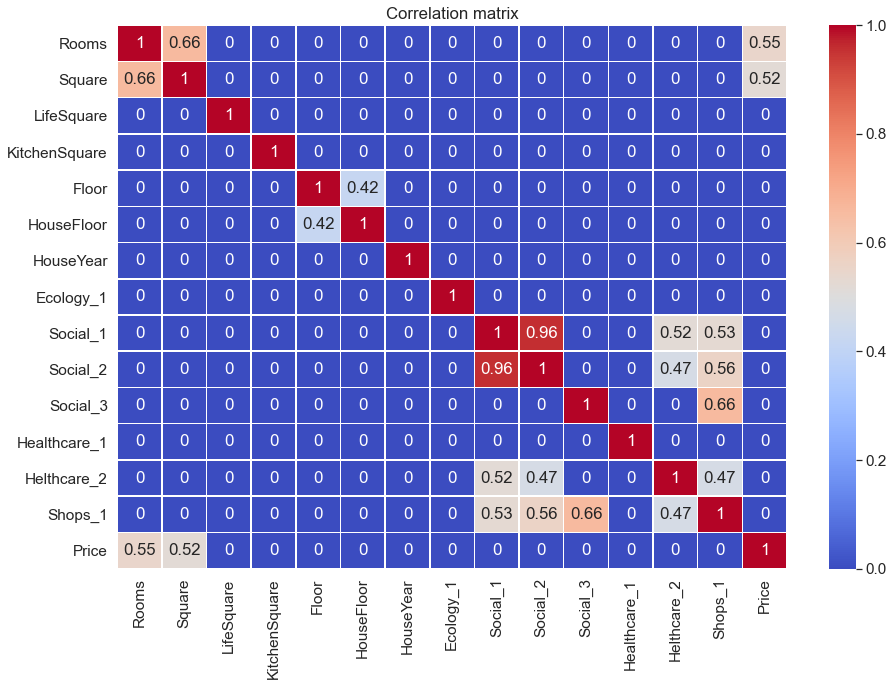

In [18]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Сильная линейная зависимоть признаков Social_1 и Social_2

# 4. Обработка исходных данных <a class='anchor' id='prep'>

## 4.1. Обработка выбросов <a class='anchor' id='outlier'>

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### 4.1.1. Square <a class='anchor' id='square'>

In [20]:
train_df['Square'].quantile(.99), train_df['Square'].quantile(.001)

(117.85611482113002, 5.128916069316165)

In [21]:
condition_max = (train_df['Square'].isna()) \
             | (train_df['Square'] > train_df['Square'].quantile(.99))
condition_min = (train_df['Square'] < 20)

train_df['Square_outlier'] = 0
train_df.loc[condition_max | condition_min, 'Square_outlier'] = 1  
train_df.loc[condition_max, 'Square'] = train_df['Square'].median()  
train_df.loc[condition_min, 'Square'] = 20

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier
Id,,,,,,,,,,,,,,,,,,,,
11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


### 4.1.2. KitchenSquare <a class='anchor' id='kitchen_square'>

In [22]:
train_df['KitchenSquare'].quantile(.99), train_df['KitchenSquare'].quantile(.001)

(16.0, 0.0)

In [23]:
condition_max = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['Square'].quantile(.99))
condition_min = (train_df['KitchenSquare'] < 3)

train_df['KitchenSquare_outlier'] = 0
train_df.loc[condition_max | condition_min, 'KitchenSquare_outlier'] = 1  
train_df.loc[condition_max, 'KitchenSquare'] = train_df['KitchenSquare'].median()  
train_df.loc[condition_min, 'KitchenSquare'] = 3

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
2352,1,1,40.409907,NaN,3.0,10,22,1977,0.007122,B,...,1,264,0,NaN,0,1,B,168106.007630,0,1
13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


### 4.1.3. LifeSquare <a class='anchor' id='life_square'>

In [24]:
train_df['Square'].quantile(.99), train_df['Square'].quantile(.001)

(103.62208961332054, 20.0)

In [25]:
condition_max = (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.99))
condition_min = (train_df['LifeSquare'] < 15)
condition_lim = (train_df['LifeSquare'] > train_df['Square']) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())

train_df['LifeSquare_outlier'] = 0
train_df.loc[condition_max | condition_min, 'LifeSquare_outlier'] = 1  
train_df.loc[condition_max, 'LifeSquare'] = train_df['LifeSquare'].median()  
train_df.loc[condition_min, 'LifeSquare'] = 15
train_df.loc[condition_lim, 'LifeSquare'] = train_df.loc[condition_lim, 'Square'] \
                                            - train_df.loc[condition_lim, 'KitchenSquare'] - 3

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,...,3097,0,NaN,0,0,B,305018.871089,0,0,0
3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
2352,1,1,40.409907,NaN,3.0,10,22,1977,0.007122,B,...,264,0,NaN,0,1,B,168106.007630,0,1,0
13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,...,8667,2,NaN,0,6,B,343995.102962,0,0,0


In [26]:
train_df['LifeSquare'].isna().sum()

2113

### 4.1.4. Rooms <a class='anchor' id='rooms'>

In [27]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [28]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10,2014,0.075424,B,...,0,NaN,0,0,B,305018.871089,0,0,0,0
3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,B,...,1,1183.0,1,0,B,177734.553407,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,B,...,0,240.0,3,1,B,282078.720850,0,0,0,0
2352,1,1.0,40.409907,NaN,3.0,10,22,1977,0.007122,B,...,0,NaN,0,1,B,168106.007630,0,1,0,0
13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,B,...,2,NaN,0,6,B,343995.102962,0,0,0,0


In [29]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### 4.1.5. HouseFloor, Floor <a class='anchor' id='house_floor'>

In [30]:
train_df['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
38        1
31        1
45        1
117       1
29        1
44        1
36        1
26        1
47        1
Name: HouseFloor, dtype: int64

In [31]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [33]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10,2014,0.075424,B,...,NaN,0,0,B,305018.871089,0,0,0,0,0
3013,22,1.0,39.832524,23.169223,8.0,7,8,1966,0.118537,B,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17,1988,0.025609,B,...,240.0,3,1,B,282078.720850,0,0,0,0,0
2352,1,1.0,40.409907,NaN,3.0,10,22,1977,0.007122,B,...,NaN,0,1,B,168106.007630,0,1,0,0,0
13866,94,2.0,64.285067,38.562517,9.0,16,16,1972,0.282798,B,...,NaN,0,6,B,343995.102962,0,0,0,0,0


In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median() # заполнить пропуски этажности медианой
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor'] = train_df['Floor'] # заменить этажность на текущий этаж, если он превышает этажность
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,...,NaN,0,0,B,305018.871089,0,0,0,0,0
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,...,240.0,3,1,B,282078.720850,0,0,0,0,0
2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,...,NaN,0,1,B,168106.007630,0,1,0,0,0
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,...,NaN,0,6,B,343995.102962,0,0,0,0,0


In [35]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

### 4.1.6. HouseYear <a class='anchor' id='house_year'>

In [36]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
8892         2020
2530         2020
9600         2020
           ...   
7920         1916
6751         1914
14556        1912
2085         1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [37]:
current_year = datetime.now().year
        
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,...,0,0,B,305018.871089,0,0,0,0,0,0
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,...,1,0,B,177734.553407,0,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,...,3,1,B,282078.720850,0,0,0,0,0,0
2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,...,0,1,B,168106.007630,0,1,0,0,0,0
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,...,0,6,B,343995.102962,0,0,0,0,0,0


In [38]:
train_df['HouseYear'].sort_values(ascending=False)

Id
11607    2021
10814    2021
8892     2020
2530     2020
9600     2020
         ... 
7920     1916
6751     1914
14556    1912
2085     1912
13288    1910
Name: HouseYear, Length: 10000, dtype: int64

## 4.2. Обработка пропусков <a class='anchor' id='nan'>

### 4.2.1. Healthcare_1 <a class='anchor' id='healthcare_1'>

In [39]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1

train_df.loc[(train_df['Healthcare_1'].isna()), 'Healthcare_1'] = train_df['Healthcare_1'].median()
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,...,0,B,305018.871089,0,0,0,0,0,0,1
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,...,0,B,177734.553407,0,0,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,...,1,B,282078.720850,0,0,0,0,0,0,0
2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,...,1,B,168106.007630,0,1,0,0,0,0,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,...,6,B,343995.102962,0,0,0,0,0,0,1


### 4.2.2. LifeSquare <a class='anchor' id='life_square_nan'>

In [40]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
# заполнение пропуска разностью Square и KitchenSquare + 3
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,B,...,B,305018.871089,0,0,0,0,0,0,1,1
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,...,B,177734.553407,0,0,0,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,...,B,282078.720850,0,0,0,0,0,0,0,0
2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,B,...,B,168106.007630,0,1,0,0,0,0,1,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,...,B,343995.102962,0,0,0,0,0,0,1,0


## 4.3. Подготовка исходных данных <a class='anchor' id='prep_script'>

In [41]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.square_quantile = None
        self.kitchen_square_quantile = None
        self.life_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан и квантилей
        self.medians = X.median()
        self.square_quantile = X['Square'].quantile(.99)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.99)
        self.life_square_quantile = X['LifeSquare'].quantile(.99)
    
    def transform(self, X):
        """Трансформация данных"""

         # Square
        condition_max = (X['Square'].isna()) \
             | (X['Square'] > X['Square'].quantile(.99))
        condition_min = (X['Square'] < 20)

        X['Square_outlier'] = 0
        X.loc[condition_max | condition_min, 'Square_outlier'] = 1  
        X.loc[condition_max, 'Square'] = self.medians['Square']  
        X.loc[condition_min, 'Square'] = 20
                
        # KitchenSquare        
        condition_max = (X['KitchenSquare'].isna()) \
             | (X['KitchenSquare'] > X['Square'].quantile(.99))
        condition_min = (X['KitchenSquare'] < 3)

        X['KitchenSquare_outlier'] = 0
        X.loc[condition_max | condition_min, 'KitchenSquare_outlier'] = 1  
        X.loc[condition_max, 'KitchenSquare'] = self.medians['KitchenSquare']  
        X.loc[condition_min, 'KitchenSquare'] = 3
        
        # LifeSquare_outliers  
        condition_max = (X['LifeSquare'] > X['LifeSquare'].quantile(.99))
        condition_min = (X['LifeSquare'] < 15)
        condition_lim = (X['LifeSquare'] > X['Square']) \
             & (~X['Square'].isna()) \
             & (~X['KitchenSquare'].isna())

        X['LifeSquare_outlier'] = 0
        X.loc[condition_max | condition_min, 'LifeSquare_outlier'] = 1  
        X.loc[condition_max, 'LifeSquare'] = self.medians['LifeSquare'] 
        X.loc[condition_min, 'LifeSquare'] = 15
        X.loc[condition_lim, 'LifeSquare'] = X.loc[condition_lim, 'Square'] - X.loc[condition_lim, 'KitchenSquare'] - 3
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
       
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = X['Floor'] 
            
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        X.loc[(X['Healthcare_1'].isna()), 'Healthcare_1'] = self.medians['Healthcare_1']
            
        # LifeSquare_nan
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # заполнение остальных неучтенных пропусков медианами
        X.fillna(self.medians, inplace=True) 
        
        return X

# 5. Построение новых признаков <a class='anchor' id='new_features'>

## 5.1. Ecology_2, Ecology_3, Shops_2 <a class='anchor' id='binary'>

In [42]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,1,305018.871089,0,0,0,0,0,0,1,1
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,1,177734.553407,0,0,0,0,0,0,0,0
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,1,282078.720850,0,0,0,0,0,0,0,0
2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,1,168106.007630,0,1,0,0,0,0,1,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,1,343995.102962,0,0,0,0,0,0,1,0


## 5.2. DistrictSize, IsDistrictLarge <a class='anchor' id='district_size'>

In [43]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [44]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,305018.871089,0,0,0,0,0,0,1,1,851
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,177734.553407,0,0,0,0,0,0,0,0,78
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,282078.720850,0,0,0,0,0,0,0,0,652
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,168106.007630,0,1,0,0,0,0,1,1,652
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,343995.102962,0,0,0,0,0,0,1,0,89


In [45]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,0,0,0,0,0,1,1,851,1
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,0,0,0,0,78,0
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,0,0,0,0,652,1
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,0,1,0,0,0,0,1,1,652,1
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,0,0,0,0,0,1,0,89,0


## 5.3. MedPriceByDistrict <a class='anchor' id='med_price_by_district'>

In [46]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [47]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,KitchenSquare_outlier,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,0,0,0,0,1,1,851,1,213530.788443
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,0,0,0,78,0,146032.829834
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,0,0,0,652,1,244005.272380
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,1,0,0,0,0,1,1,652,1,146735.671740
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,0,0,0,0,1,0,89,0,201584.441255


## 5.4. Floor_cat <a class='anchor' id='floor_cat'>

In [48]:
train_df['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [49]:
def floor_to_cat(X):
    """Категории домов в зависимости от этажа"""

    X['Floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'Floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'Floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'Floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'Floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'Floor_cat'] = 5

    return X

In [50]:
train_df = floor_to_cat(train_df)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_outlier,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,0,0,0,1,1,851,1,213530.788443,2
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,0,0,78,0,146032.829834,3
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,0,0,652,1,244005.272380,1
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,0,0,0,0,1,1,652,1,146735.671740,4
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,0,0,0,1,0,89,0,201584.441255,5


## 5.5. Year_cat <a class='anchor' id='year_cat'>

In [51]:
train_df['HouseYear'].describe()

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

In [52]:
def year_to_cat(X):
    """Категории домов в зависимости от года постройки"""

    X['Year_cat'] = 0

    X.loc[X['HouseYear'] >= 2000, 'Year_cat'] = 1  
    X.loc[(X['HouseYear'] < 2000) & (X['HouseYear'] >= 1990), 'Year_cat'] = 2
    X.loc[(X['HouseYear'] < 1990) & (X['HouseYear'] >= 1975), 'Year_cat'] = 3
    X.loc[(X['HouseYear'] < 1975) & (X['HouseYear'] >= 1950), 'Year_cat'] = 4
    X.loc[X['HouseYear'] < 1950, 'Year_cat'] = 5
    
    return X

In [53]:
train_df = year_to_cat(train_df)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,0,0,1,1,851,1,213530.788443,2,1
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,0,78,0,146032.829834,3,4
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,0,652,1,244005.272380,1,3
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,0,0,0,1,1,652,1,146735.671740,4,3
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,0,0,1,0,89,0,201584.441255,5,4


## 5.6. MedPriceByFloor <a class='anchor' id='med_price_by_floor'>

In [54]:
med_price_by_floor = train_df.groupby(['Floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloor'})
med_price_by_floor.head()

,Floor_cat,MedPriceByFloor
0,1,180452.272989
1,2,189794.273739
2,3,195100.816597
3,4,197106.182453
4,5,205859.630791


In [55]:
train_df = train_df.merge(med_price_by_floor, on=['Floor_cat'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloor
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,0,1,1,851,1,213530.788443,2,1,189794.273739
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,78,0,146032.829834,3,4,195100.816597
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,652,1,244005.272380,1,3,180452.272989
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,0,0,1,1,652,1,146735.671740,4,3,197106.182453
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,0,1,0,89,0,201584.441255,5,4,205859.630791


## 5.7. MedPriceByYear <a class='anchor' id='med_price_by_year'>

In [56]:
med_price_by_year = train_df.groupby(['Year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
med_price_by_year.head()

,Year_cat,MedPriceByYear
0,1,197829.325338
1,2,231972.743475
2,3,184290.220735
3,4,194175.395111
4,5,362698.813373


In [57]:
train_df = train_df.merge(med_price_by_year, on=['Year_cat'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseYear_outlier,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloor,MedPriceByYear
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,0,1,1,851,1,213530.788443,2,1,189794.273739,197829.325338
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,0,78,0,146032.829834,3,4,195100.816597,194175.395111
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,0,652,1,244005.272380,1,3,180452.272989,184290.220735
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,0,1,1,652,1,146735.671740,4,3,197106.182453,184290.220735
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,1,0,89,0,201584.441255,5,4,205859.630791,194175.395111


## 5.8. MedPriceByRooms <a class='anchor' id='med_price_by_rooms'>

In [58]:
med_price_by_room = train_df.groupby(['Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByRoom'})
med_price_by_room.head()

,Rooms,MedPriceByRoom
0,1.0,155012.207721
1,2.0,200320.754636
2,3.0,268723.157677
3,4.0,377524.231990
4,5.0,455355.638212


In [59]:
train_df = train_df.merge(med_price_by_room, on=['Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1_nan,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloor,MedPriceByYear,MedPriceByRoom
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,1,1,851,1,213530.788443,2,1,189794.273739,197829.325338,268723.157677
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,0,78,0,146032.829834,3,4,195100.816597,194175.395111,155012.207721
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,0,652,1,244005.272380,1,3,180452.272989,184290.220735,268723.157677
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,1,1,652,1,146735.671740,4,3,197106.182453,184290.220735,155012.207721
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,1,0,89,0,201584.441255,5,4,205859.630791,194175.395111,200320.754636


## 5.9. Med_District_Price <a class='anchor' id='med_district_price'>

In [60]:
med_district_price = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'Med_District_Price'})
med_district_price.head()

,DistrictId,Med_District_Price
0,0,165963.054142
1,1,183663.443595
2,10,217749.656911
3,100,234032.836228
4,101,184276.502773


In [61]:
train_df = train_df.merge(med_district_price, on=['DistrictId'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloor,MedPriceByYear,MedPriceByRoom,Med_District_Price
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,1,851,1,213530.788443,2,1,189794.273739,197829.325338,268723.157677,146171.433190
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,...,0,78,0,146032.829834,3,4,195100.816597,194175.395111,155012.207721,183678.134031
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,...,0,652,1,244005.272380,1,3,180452.272989,184290.220735,268723.157677,183663.443595
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,1,652,1,146735.671740,4,3,197106.182453,184290.220735,155012.207721,183663.443595
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,...,0,89,0,201584.441255,5,4,205859.630791,194175.395111,200320.754636,181706.718894


## 5.10. LifeSquareShare <a class='anchor' id='life_square_share'>

In [62]:
# доля жилой площади относительно общей
train_df['LifeSquareShare'] = train_df['LifeSquare'] / train_df['Square'] * 100
train_df[train_df['LifeSquareShare'] > 80].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Floor_cat,Year_cat,MedPriceByFloor,MedPriceByYear,MedPriceByRoom,Med_District_Price,LifeSquareShare
0,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,...,851,1,213530.788443,2,1,189794.273739,197829.325338,268723.157677,146171.433190,88.698336
3,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,...,652,1,146735.671740,4,3,197106.182453,184290.220735,155012.207721,183663.443595,85.152156
8,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,1,...,652,1,146735.671740,4,3,197106.182453,184290.220735,155012.207721,183663.443595,95.180504
9,6,3.0,79.867477,75.085125,3.0,3,17.0,2014,0.243205,1,...,511,1,215707.925347,1,1,180452.272989,197829.325338,268723.157677,168980.370846,94.012142
18,1,1.0,47.582480,41.582480,3.0,16,16.0,1977,0.007122,1,...,652,1,146735.671740,5,3,205859.630791,184290.220735,155012.207721,183663.443595,87.390317


## 5.11. Генерация новых признаков <a class='anchor' id='feature_generator'>

In [63]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor = None
        self.med_price_by_year = None
        self.med_price_by_rooms = None
        self.med_district_price = None
        self.house_year_max = None
        self.floor_max = None
        self.rooms_max = None
        self.distict_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        ## District, Rooms, DistrictMed
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
                       
            self.med_district_price = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'Med_District_Price'})
            
            self.med_district_price_median = self.med_district_price['Med_District_Price'].median()
            
        ## Floor
        if y is not None:
            self.floor_max = df['Floor'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            self.med_price_by_floor = df.groupby(['Floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloor'})
            self.med_price_by_floor_median = self.med_price_by_floor['MedPriceByFloor'].median()
        
        ## Year
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_year = df.groupby(['Year_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
            self.med_price_by_year_median = self.med_price_by_year['MedPriceByYear'].median()

        ## Rooms
        if y is not None:
            self.rooms_max = df['Rooms'].max()
            df['Price'] = y.values
            self.med_price_by_rooms = df.groupby(['Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByRooms'})
            self.med_price_by_rooms_median = self.med_price_by_rooms['MedPriceByRooms'].median()

    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # LifeSquareShare
        X['LifeSquareShare'] = X['LifeSquare'] / train_df['Square'] * 100
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец Floor_cat
        X = self.year_to_cat(X)   # + столбец Year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor is not None:
            X = X.merge(self.med_price_by_floor, on=['Floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_median, inplace=True)
        
        if self.med_price_by_year is not None:
            X = X.merge(self.med_price_by_year, on=['Year_cat'], how='left')
            X.fillna(self.med_price_by_year_median, inplace=True)
            
        if self.med_price_by_rooms is not None:
            X = X.merge(self.med_price_by_rooms, on=['Rooms'], how='left')
            X.fillna(self.med_price_by_rooms_median, inplace=True)
   
        if self.med_district_price is not None:
            X = X.merge(self.med_district_price, on=['DistrictId'], how='left')
            X.fillna(self.med_district_price_median, inplace=True)
        return X
        
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['Floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['Floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1950, 1975, 1990, 2000, self.house_year_max]
        X['Year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['Year_cat'].fillna(-1, inplace=True)
        return X    

# 6. Отбор признаков <a class='anchor' id='feature_select'>

In [64]:
col_list = train_df.copy()
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [65]:
col_list.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_outlier',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'Healthcare_1_nan',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Floor_cat',
 'Year_cat',
 'MedPriceByFloor',
 'MedPriceByYear',
 'MedPriceByRoom',
 'Med_District_Price',
 'LifeSquareShare']

In [66]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Helthcare_2']

new_feature_names = ['DistrictSize', 'LifeSquareShare', 'Square_outlier', 'MedPriceByRooms']

target_name = 'Price'

In [67]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

# 7. Разбиение на train и test <a class='anchor' id='ds_separating'>

In [68]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B


In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [70]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [71]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 38), (3300, 38), (5000, 38))

In [72]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

# 8. Построение модели <a class='anchor' id='model'>

## 8.1. Подбор параметров <a class='anchor' id='parameters'>

In [73]:
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'min_samples_leaf': np.arange(5, 12),
    'max_depth': np.arange(5, 9),
}

In [74]:
gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [88]:
# gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': array([5, 6, 7, 8]),
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11]),
                         'n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [89]:
# gb.best_params_

{'max_depth': 5, 'min_samples_leaf': 8, 'n_estimators': 150}

## 8.2. Обучение модели <a class='anchor' id='learn'>

In [90]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=8,
                                     random_state=42,  
                                     n_estimators=150)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=8,
                          n_estimators=150, random_state=42)

# 9. Оценка модели <a class='anchor' id='estimation'>

## 9.1. Функция evaluate_preds <a class='anchor' id='evaluate_preds'>

Train R2:	0.874
Test R2:	0.743


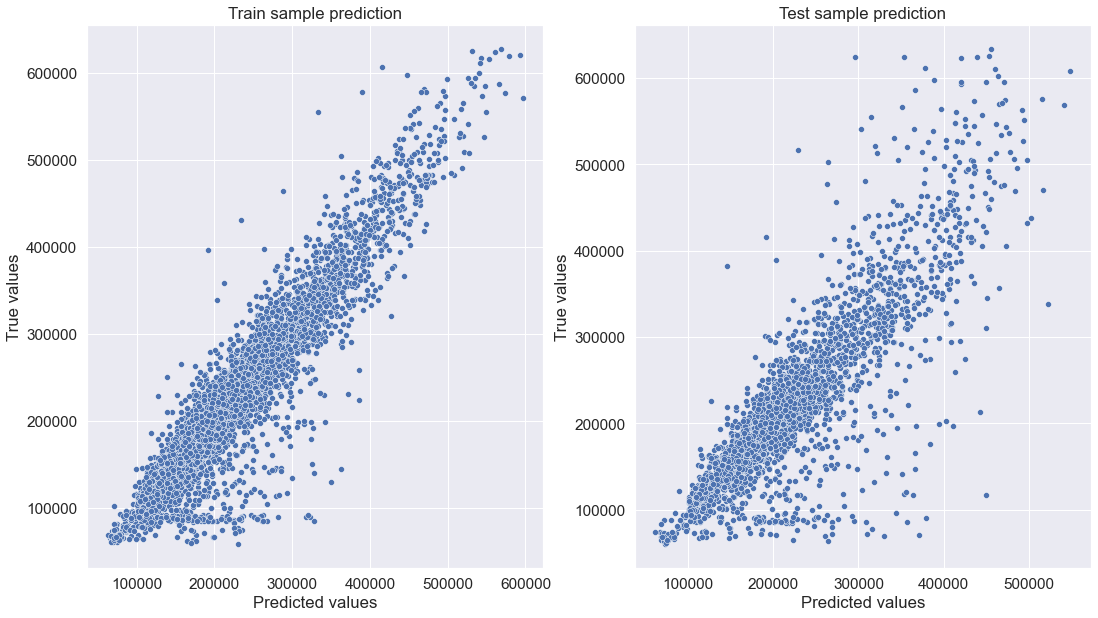

In [91]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Пробовал модели:
- LinearRegression;
- RandomForestRegressor;
- GradientBoostingRegressor;
- StackingRegressor.

Среди них лучший показатель r2 оказался у GradientBoostingRegressor

## 9.2. Кросс валидация <a class='anchor' id='cross_validation'>

In [79]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.72764286, 0.69947419, 0.71599653])

In [80]:
cv_score.mean()

0.7143711909170253

## 9.3. Важность признаков <a class='anchor' id='feature_importances'>

In [81]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.398511
14,DistrictSize,0.255250
11,Social_3,0.056960
1,Rooms,0.039850
8,Ecology_1,0.031536
10,Social_2,0.031050
7,HouseYear,0.027586
0,DistrictId,0.026167
6,HouseFloor,0.023619
16,Square_outlier,0.021053


# 10. Прогнозирование на тестовом датасете <a class='anchor' id='predictions'> 

In [82]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Shops_1,Helthcare_2,DistrictSize,LifeSquareShare,Square_outlier,MedPriceByRooms
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,4378,0,1,1,70.0,16.599695,0,154711.917939
1,62,1.0,42.493907,29.493907,10.0,7,17.0,2017,0.072158,2,629,1,0,0,164.0,74.044786,0,154711.917939
2,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,9,1892,0,1,0,568.0,60.585060,0,200378.608978
3,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,475,0,0,0,375.0,83.875039,0,264544.837338
4,74,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,35,7715,4,6,0,76.0,74.413946,0,154711.917939


In [83]:
submit = pd.read_csv('./sample_submission.csv') # пример требуемого результата
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [84]:
predictions = gb_model.predict(test_df)
predictions

array([166423.86793345, 119614.85731711, 148657.10765261, ...,
       142525.36159597, 193075.05154627, 255330.68869426])

In [85]:
submit['Price'] = predictions # замена целевой переменной в файле с примером результата
submit.head()

,Id,Price
0,4567,166423.867933
1,5925,119614.857317
2,960,148657.107653
3,3848,123307.542199
4,746,206108.990193


In [86]:
submit.to_csv('gb_submit.csv', index=False)

In [87]:
result_view = pd.read_csv('./gb_submit.csv') # для проверки результата
result_view.head()

,Id,Price
0,4567,166423.867933
1,5925,119614.857317
2,960,148657.107653
3,3848,123307.542199
4,746,206108.990193
